In [1]:
# ===============================================================================================================#
#
# Copyright 2021 Infosys Ltd.
# Use of this source code is governed by Apache License Version 2.0 that can be found in the LICENSE file or at
# http://www.apache.org/licenses/
#
# ===============================================================================================================#

## 1. Preparation

In [2]:
import json
from libraries._internal_utils.demo_helper import DemoHelper
import pandas as pd
from IPython.display import Image

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="bs4.builder")

#### <span style='color:blue'>Enter image and OCR file paths</span>

In [4]:
IMAGE_PATH="./data/radiobutton.png"
IMAGE_OCR_PATH='./data/radiobutton.hocr'
TEMP_FOLDER_PATH = './data/temp'

#### Visualize

In [5]:
IMAGE_PATHS=[IMAGE_PATH]
tab_widget = DemoHelper.create_tab_toolbar(IMAGE_PATHS)
display(tab_widget)
for idx, image_path in enumerate(IMAGE_PATHS):
    with tab_widget.children[idx]:
        display(Image(filename=image_path, width=800, height=50))

## 2. Initialization

#### <span style='color:blue'>Create new instance with desired OCR service provider</span>

### 1.1. Example - Create Instance - With logging

In [6]:
from infy_field_extractor import radio_button_extractor
from infy_field_extractor.providers.ocr_data_service_provider import OcrDataServiceProvider
from infy_ocr_parser.providers.tesseract_ocr_data_service_provider import TesseractOcrDataServiceProvider
from infy_ocr_parser import ocr_parser
import logging
import os

if not os.path.exists('./logs'):
    os.makedirs('./logs')

if not os.path.exists(TEMP_FOLDER_PATH):
    os.makedirs(TEMP_FOLDER_PATH)      
    
logging.basicConfig(filename=('./logs' + '/app_log.log'),
                format='%(asctime)s- %(levelname)s- %(message)s',
                level=logging.CRITICAL, datefmt='%d-%b-%y %H:%M:%S')
logger = logging.getLogger() 
logger.info('log initialized')

data_service_provider = TesseractOcrDataServiceProvider()
ocr_parser_object = ocr_parser.OcrParser(ocr_file_list=[IMAGE_OCR_PATH],
                                         data_service_provider=data_service_provider)
provider = OcrDataServiceProvider(ocr_parser_object)
    
radiobutton_obj = radio_button_extractor.RadioButtonExtractor(provider,provider,temp_folderpath=TEMP_FOLDER_PATH, 
                                                              logger = logger, debug_mode_check = False)

2023-12-07 19:16:15,802.802 INFO [MainThread] [data_service_provider_interface] [__set_logger:112] log initialized
2023-12-07 19:16:15,827.827 INFO [MainThread] [data_service_provider_interface] [__set_logger:145] log initialized


## 3. API - extract_custom_fields()

### 3.1. Example

In this example "field_key" and "field_state_pos" is required. It searches for the "field_key" in the image using ocr_parser_obj and extracts the state of the nearest radio button to the "field_key" in the direction given by the param "field_state_pos". If "field_state_pos" not given, it dynamically searches the nearest radio button in all the direction and extracts the state.

In [7]:
radiobutton_field_data_list = [
    {
        "field_key": [
            "incorporator"
        ],
        "field_state_pos": "left"
    },
    {
        "field_key": [
            "initial director"
        ],
        "field_state_pos": "left"
    }
]
output = radiobutton_obj.extract_custom_fields(image_path = IMAGE_PATH, 
        radiobutton_field_data_list = radiobutton_field_data_list)

#### Output

In [8]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields'])
print('No. of records found =', len(df))
df

No. of records found = 2


,field_key,field_state,error
0,[incorporator],False,None
1,[initial director],True,None


#### Visualize

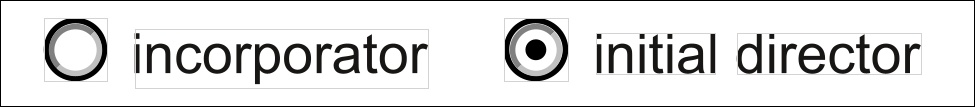

In [9]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=1, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)

DemoHelper.show_image(img)

### 3.2. Example

In this example "field_state_bbox" is required and "field_key" is optional. For each element in the radiobutton_field_data_list, it expects to find one radiobutton within the region given by the "field_state_bbox" param and extracts the state of that radiobutton.

In [10]:
radiobutton_field_data_list = [
    {
        "field_key": [
            "incorporator"
        ],
        "field_state_bbox": [
            30,
            9,
            87,
            78
        ]
    }
]

output = radiobutton_obj.extract_custom_fields(image_path = IMAGE_PATH, 
        radiobutton_field_data_list = radiobutton_field_data_list)

#### Output

In [11]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields'])
print('No. of records found =', len(df))
df

No. of records found = 1


,field_key,field_state_bbox,field_state,error
0,[incorporator],"[30, 9, 87, 78]",False,None


#### Visualize

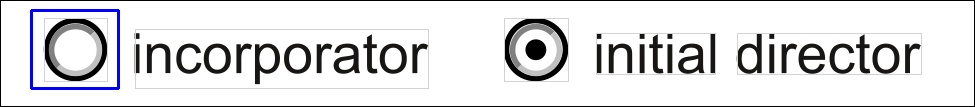

In [12]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

field_state_bboxes = [x['field_state_bbox'] for x in radiobutton_field_data_list]
all_bboxes = field_state_bboxes 
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=1, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)
img = DemoHelper.draw_bboxes_on_image(img, field_state_bboxes, border_thickness=2,
                                         border_color = DemoHelper.Constants.COLOR_BLUE)
img = DemoHelper.reduce_image_based_on_context(img, all_bboxes)

DemoHelper.show_image(img)

## 4. API - extract_all_fields()

`TEMPLATE_CHECKED_FOLDER` and `TEMPLATE_UNCHECKED_FOLDER` contains samples of checked and unchecked radio buttons. The templates in the folder must be a cropped from the image. It uses template match to exactly match all the radiobuttons in that image or a same template image of same DPI.

### 4.1. Example

In [13]:
TEMPLATE_CHECKED_FOLDER = './data/template/checked'
TEMPLATE_UNCHECKED_FOLDER = './data/template/unchecked'

CONFIG_PARAMS_DICT = {
    "template_checked_folder":TEMPLATE_CHECKED_FOLDER, 
    "template_unchecked_folder":TEMPLATE_UNCHECKED_FOLDER
}

output = radiobutton_obj.extract_all_fields(image_path=IMAGE_PATH,
                                            config_params_dict=CONFIG_PARAMS_DICT)

C:\IPCELL-VENV\notebook-wE18krVG\lib\site-packages\infy_field_extractor\internal\extractor_helper.py:286: UserWarning: The result might be not accurate due to low dpi
  warnings.warn(warning)


#### Output

In [14]:
# print(json.dumps(output, indent=4))
df = pd.json_normalize(output['fields']).T
print('No. of records found =', len(df))
df

No. of records found = 2


,0
initial director,True
incorporator,False


#### Visualize

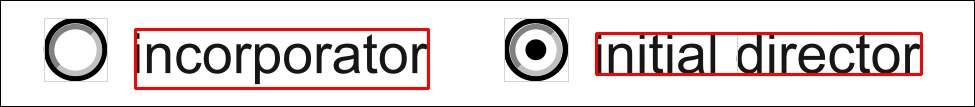

In [15]:
# Get all tokens i.e. without any bounding box restrictions
all_tokens = ocr_parser_object.get_tokens_from_ocr(
    token_type_value=1,     
    pages=[1]
)
all_tokens_text_bboxes = [x['bbox'] for x in all_tokens]

text_bboxes = [x['bbox'] for x in output['fieldsList']]
all_bboxes = text_bboxes 
img = DemoHelper.read_image(IMAGE_PATH)
img = DemoHelper.draw_bboxes_on_image(img, all_tokens_text_bboxes, border_thickness=1, 
                                         border_color = DemoHelper.Constants.COLOR_GRAY)
img = DemoHelper.draw_bboxes_on_image(img, text_bboxes, border_thickness=2,
                                         border_color = DemoHelper.Constants.COLOR_RED)
img = DemoHelper.reduce_image_based_on_context(img, all_bboxes)

DemoHelper.show_image(img)